# Dataset

- NUAA Imposter Database (2010) is used for this experiment. This face spoof database has photo attack samples.

- Import required libraries.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile 
import numpy as np
import cv2
import os
import pandas as pd
import seaborn as sns
from skimage import io, color
from skimage.feature import local_binary_pattern


## EDA

### Files and folders for data processing

- Unzip dataset folder

In [2]:
warnings.filterwarnings('ignore')
from zipfile import ZipFile 
import numpy as np
import cv2
data_dir = "raw.zip"  
with ZipFile(data_dir, 'r') as zip: 
    zip.extractall()

- "raw.zip" is the dataset zip file. "raw" folder has two subfolders for client and imposter images. These images are post face detection images in '.jpg' format. This folder also incudes lists of client train images, cient test images, imposter test images and imposter train images.

In [3]:
raw_dir_list= os.listdir('raw/')
print(raw_dir_list)

['ClientRaw', 'client_test_raw.txt', 'client_train_raw.txt', 'ImposterRaw', 'imposter_test_raw.txt', 'imposter_train_raw.txt', 'readme.txt']


In [4]:
clientFolder= os.path.join('raw/ClientRaw/')
imposterFolder = os.path.join('raw/ImposterRaw/')
clientTestList =os.path.join('raw/client_test_raw.txt')
clientTrainList =os.path.join('raw/client_train_raw.txt')
imposterTestList =os.path.join('raw/imposter_test_raw.txt')
imposterTrainList =os.path.join('raw/imposter_train_raw.txt')

- In NUAA Imposter Dataset, "ClientFace" and "ImposterFace" folders have subfolders curresponding to each subject. 15 subjects were considered to record the dataset. In "ImposterFace" has subject 16 instead of subject 13.

In [5]:
clientface_dir_list= os.listdir(clientFolder)
#print('ClientFace Directory List:',clientface_dir_list)
imposterface_dir_list= os.listdir(imposterFolder)
#print('ImposterFace Directory List:',imposterface_dir_list)
clientface_dir_list.sort()
imposterface_dir_list.sort()
client_IdList=clientface_dir_list
imposter_IdList=imposterface_dir_list
print('Client Subject Id List:',client_IdList)
print('Imposter Subject Id List:',imposter_IdList)

Client Subject Id List: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015']
Imposter Subject Id List: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0014', '0015', '0016']


- Function to create list by reading currespoding .txt files and modifying file paths

In [6]:
def get_list(inlist):
  temp_list=[]
  # open file and read the content in a list
  with open(inlist, 'r') as f1:
    for line in f1:
        # remove linebreak which is the last character of the string
        c_line = line[:-1]
        # add item to the list
        temp_list.append(c_line)
  if ((f1.name.split('/')[1])[0]=='c' ):
    Folder=clientFolder
  else:
    Folder=imposterFolder       
  for i in range(len(temp_list)):
    temp_list[i]=(temp_list[i].split(' '))[0]
    temp_list[i]=  temp_list[i].replace('\\','/')
    temp_list[i]=os.path.join(Folder+temp_list[i])
  return temp_list

In [7]:
c_train_list= get_list(clientTrainList)
print('Number of images in client train set:',len(c_train_list))
i_train_list=get_list(imposterTrainList)
print('Number of images in imposter train set:',len(i_train_list))
c_test_list= get_list(clientTestList)
print('Number of images in client test set:',len(c_test_list))
i_test_list=get_list(imposterTestList)
print('Number of images in imposter test set:',len(i_test_list))

print('dataset size:',len(c_train_list)+len(i_train_list)+len(c_test_list)+len(i_test_list))


train_list =[]
train_list.extend(c_train_list)
train_list.extend(i_train_list)
print('Number of images in train set:',len(train_list))
test_list =[]
test_list.extend(c_test_list)
test_list.extend(i_test_list)
print('Number of images in test set',len(test_list))

Number of images in client train set: 1743
Number of images in imposter train set: 1748
Number of images in client test set: 3362
Number of images in imposter test set: 5761
dataset size: 12614
Number of images in train set: 3491
Number of images in test set 9123


In [8]:
dataset=[]
dataset.extend(train_list)
dataset.extend(test_list)

In [9]:
data_id=[]
data_class=[]
#data_set=[]

for i in range(len(dataset)):
    line=dataset[i]
    if (line.split('/')[1]=='ClientRaw'):
           
        data_class.append('client')   
    else:
        data_class.append('imposter') 
    data_id.append(line.split('/')[2])

    
# #Dataframe_Dataset
Dataset = {'Image_List':dataset,'Sub_Id':data_id,
           'Img_Class':data_class}


- Dataset size
- NUAA dataset has 12614 images. 7509 imposter images and 5105 client images.

In [10]:
df_dataset= pd.DataFrame(Dataset,columns=['Image_List','Sub_Id','Img_Class'])
print('Number of images in dataset:',len(df_dataset))
df_client=df_dataset[df_dataset.Img_Class=='client']
df_imposter=df_dataset[df_dataset.Img_Class=='imposter']
#Dispalys Client-Imposter data size
print('Number of Client images:',len(df_client))
print('Number of Imposter images:',len(df_imposter))

Number of images in dataset: 12614
Number of Client images: 5105
Number of Imposter images: 7509


- Client imposter data distribution

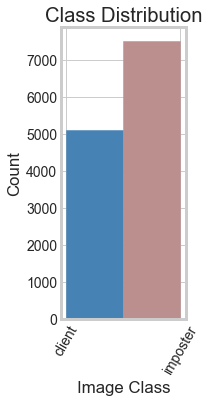

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(2,5))
n, bins, patches=plt.hist(data_class,bins=2)
patches[0].set_color('steelblue')
patches[1].set_color('rosybrown')
plt.title('Class Distribution')
plt.xlabel('Image Class')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

- The images were taken in three session to form dataset. Number of images curresponding to each subject is different.

In [12]:
pd.DataFrame({'Count':df_client['Sub_Id'].value_counts()})

,Count
0007,762
0006,730
0004,681
0014,477
0013,472
0012,435
0011,409
0001,249
0009,213
0005,190


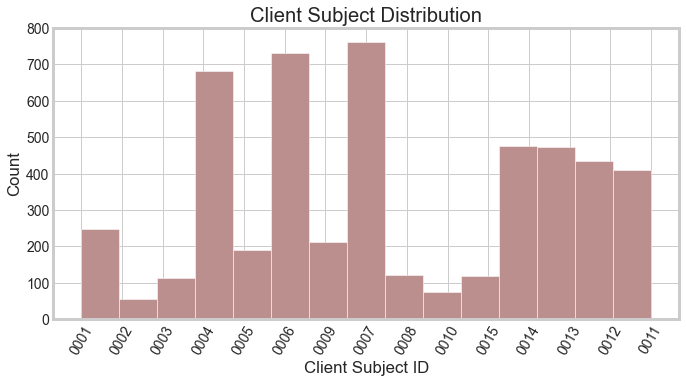

In [13]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.hist(df_client.Sub_Id,bins=15, color='rosybrown')
plt.title('Client Subject Distribution')
plt.xlabel('Client Subject ID')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

In [14]:
pd.DataFrame({'Count':df_imposter['Sub_Id'].value_counts()})

,Count
0001,614
0002,609
0004,608
0007,605
0003,603
0009,602
0008,599
0005,595
0016,468
0006,458


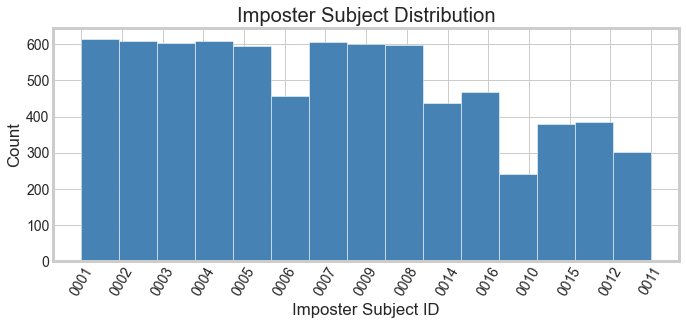

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
plt.hist(df_imposter.Sub_Id,bins=15, color='steelblue')
plt.title('Imposter Subject Distribution')
plt.xlabel('Imposter Subject ID')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

### Samples from client and imposter

random ID from cleint list is:  0013
Subejct Id is 0013. Imposter images for subject 13 is not included in dataset. Hence displaying only client images


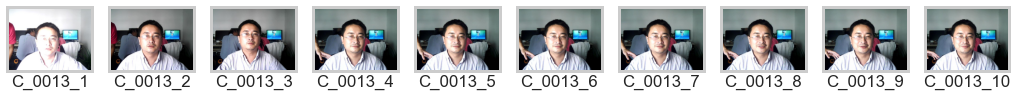

In [16]:
import random
id_rand=random.choice(client_IdList)
print("random ID from cleint list is: ", id_rand)

if (id_rand!='0016'):
    temp_df_c=df_dataset.loc[(df_dataset['Sub_Id'] == id_rand) & (df_dataset['Img_Class'] == 'client')]
    #print(temp_df)
    path_list_c=list(temp_df_c['Image_List'])
if (id_rand!='0013') :   
    #type(path_list)
    temp_df_i=df_dataset.loc[(df_dataset['Sub_Id'] == id_rand) & (df_dataset['Img_Class'] == 'imposter')]
    #print(temp_df)
    path_list_i=list(temp_df_i['Image_List'])

    
    
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

if (id_rand=='0013'):
    print("Subejct Id is 0013. Imposter images for subject 13 is not included in dataset. Hence displaying only client images")
if (id_rand=='0016'): 
    print("Subejct Id is 0016. Client images for subject 13 is not included in dataset. Hence displaying only imposter images")
list_img_i=[]
list_img_c=[]
#Client photos
if (id_rand!='0016'):
    for i in range(15):
        img_c = mpimg.imread(path_list_c[i])
        if img_c is not None:
               list_img_c.append(img_c)
    fig, ax = plt.subplots(1, 10,figsize=(16,16))   
    for i, axi in enumerate(ax.flat):
         axi.imshow(list_img_c[i], cmap='bone')
         axi.set(xticks=[], yticks=[],xlabel= 'C_'+id_rand+'_'+str(i+1))
    
    #Imposter photos
if (id_rand!='0013'):   
    for i in range(15):
        img_i = mpimg.imread(path_list_i[i])
        if img_i is not None:
               list_img_i.append(img_i)
    fig, ax = plt.subplots(1, 10,figsize=(16,16))   
    for i, axi in enumerate(ax.flat):
         axi.imshow(list_img_i[i], cmap='bone')
         axi.set(xticks=[], yticks=[],xlabel= 'I_'+id_rand+'_'+str(i+1))



In [17]:
if(id_rand!='0016'):
    img1=cv2.imread(path_list_c[0])
    print('Size of a client image:',img1.shape)
if(id_rand!='0013'):   
    img2=cv2.imread(path_list_i[0])
    print('Size of a imposter image:',img2.shape)

Size of a client image: (480, 640, 3)


## Train and test set analysis¶

In [18]:
train_id=[]
train_class=[]
for i in range(len(train_list)):
    line=train_list[i]
    if (line.split('/')[1]=='ClientRaw'):
        train_class.append('client')
    else:
        train_class.append('imposter')
    train_id.append(line.split('/')[2])  
train_set=    {'Image_List':train_list,'Sub_Id':train_id,
           'Img_Class':train_class}
df_train=pd.DataFrame(train_set,columns=['Image_List','Sub_Id','Img_Class'])

test_id=[]
test_class=[]
for i in range(len(test_list)):
    line=test_list[i]
    if (line.split('/')[1]=='ClientRaw'):
        test_class.append('client')
    else:
        test_class.append('imposter')
    test_id.append(line.split('/')[2])  
test_set=    {'Image_List':test_list,'Sub_Id':test_id,
           'Img_Class':test_class}
df_test=pd.DataFrame(test_set,columns=['Image_List','Sub_Id','Img_Class'])


- Train data distributions

In [19]:
pd.DataFrame({'Count':df_train['Sub_Id'].value_counts()})

,Count
0007,529
0001,449
0004,427
0006,419
0009,401
0005,380
0008,317
0003,312
0002,257


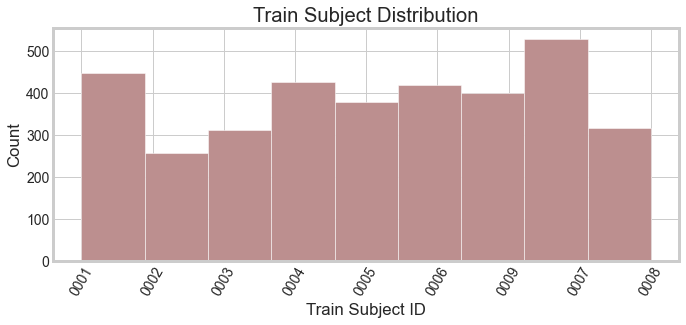

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
plt.hist(df_train.Sub_Id,bins=9, color='rosybrown')
plt.title('Train Subject Distribution')
plt.xlabel('Train Subject ID')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

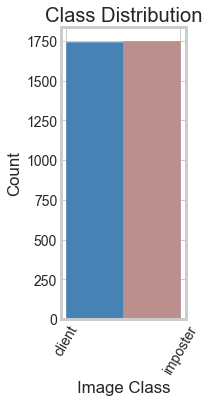

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize=(2,5))
n, bins, patches=plt.hist(df_train.Img_Class,bins=2)
patches[0].set_color('steelblue')
patches[1].set_color('rosybrown')
plt.title('Class Distribution')
plt.xlabel('Image Class')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

- Test data distributions

In [22]:
pd.DataFrame({'Count':df_test['Sub_Id'].value_counts()})

,Count
0014,916
0004,862
0007,838
0012,819
0006,769
0011,712
0015,498
0013,472
0016,468
0001,414


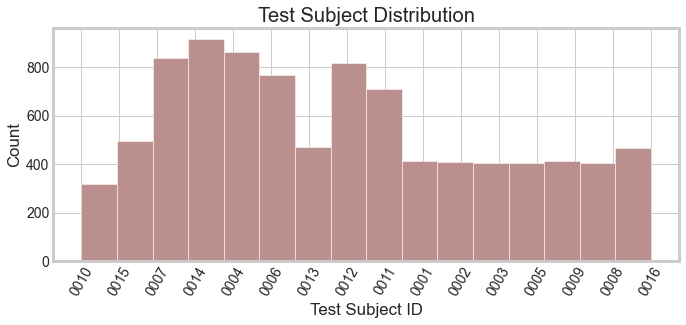

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
plt.hist(df_test.Sub_Id,bins=16, color='rosybrown')
plt.title('Test Subject Distribution')
plt.xlabel('Test Subject ID')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

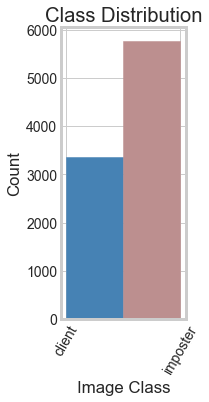

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(2,5))
n, bins, patches=plt.hist(df_test.Img_Class,bins=2)
patches[0].set_color('steelblue')
patches[1].set_color('rosybrown')
plt.title('Class Distribution')
plt.xlabel('Image Class')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

# Raw images with PCA

In [25]:
def save_img(filelist):
    
    img_list=[]
    label_list=[]
    
    for i in range(len(filelist)):
      
      line=filelist[i]
      if (line.split('/')[1]=='ClientRaw'):
            label =0   
      else:
            label=1
      label_list.append(label)  
      img = cv2.imread(line)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img= cv2.resize(img,(1,480*640))
     ## img= img.flatten()
      img_list.append(np.array(img))
    
    return np.array(img_list),np.array(label_list)

## Train and test sets

In [26]:
X_train,y_train=save_img(train_list) # train set

In [27]:
X_test,y_test=save_img(test_list) # test set

###  Size and datatype of train and test sets

In [28]:
#Print the data type of x_train
print(type(X_train))
#Print the data type of y_train
print(type(y_train))
#Print the data type of x_test
print(type(X_test))
#Print the data type of y_test
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
#Get the shape of x_train
print('X_train shape:', X_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('X_test shape:', X_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

X_train shape: (3491, 480, 640)
y_train shape: (3491,)
X_test shape: (9123, 480, 640)
y_test shape: (9123,)


In [30]:
# X_train=X_train.reshape((X_train.shape[0],480*640))
# X_test=X_test.reshape((X_test.shape[0],480*640))

In [31]:
# #Get the shape of x_train
# print('X_train shape:', X_train.shape)
# #Get the shape of y_train
# print('y_train shape:', y_train.shape)
# #Get the shape of x_train
# print('X_test shape:', X_test.shape)
# #Get the shape of y_train
# print('y_test shape:', y_test.shape)

X_train shape: (3491, 307200)
y_train shape: (3491,)
X_test shape: (9123, 307200)
y_test shape: (9123,)


## PCA- "rbf" Kernel

### Pre-process and Model’s Creation

In [37]:

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=500, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='rbf', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

### Hyperparameter Tuning

In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [39]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

MemoryError: Unable to allocate 7.99 GiB for an array with shape (3491, 307200) and data type float64

In [ ]:
# check best parameters
print(best_params)

### Best model fit

In [ ]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Result

- Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

- Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [ ]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'RAW images + PCA-rbf Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'RAW images + PCA-rbf Test HTER is {np.round(hter*100,2)}%')

- ROC Curve

In [ ]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['RAW images + PCA with rbf-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## PCA- "Linear" Kernel

###  Pre-process and Model’s Creation

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=50, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='linear', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [ ]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

In [ ]:
# check best parameters
print(best_params)

### Best model fit

In [ ]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Result

- Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

- Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [ ]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'RAW images + PCA-Linear SVM Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'RAW images + PCA-Linear SVM Test HTER is {np.round(hter*100,2)}%')

- ROC Curve

In [ ]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['RAW images + PCA with Linear-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Resize images to (64X64)- PCA

## Train and Test sets

In [25]:
def save_reimg(filelist):
    
    img_list=[]
    label_list=[]
    
    for i in range(len(filelist)):
      
      line=filelist[i]
      if (line.split('/')[1]=='ClientRaw'):
            label =0   
      else:
            label=1
      label_list.append(label)  
      img = cv2.imread(line)
      img= cv2.resize(img,(64,64))  
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img=cv2.resize(img,(1,64*64)) 
      ##img= img.flatten()
      img_list.append(np.array(img))
    
    return np.array(img_list),np.array(label_list)

In [26]:
X_train,y_train=save_reimg(train_list) # train set

In [27]:
X_test,y_test=save_reimg(test_list) # test set

### Size and datatypes of train and test sets

In [28]:
#Print the data type of x_train
print(type(X_train))
#Print the data type of y_train
print(type(y_train))
#Print the data type of x_test
print(type(X_test))
#Print the data type of y_test
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
#Get the shape of x_train
print('X_train shape:', X_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('X_test shape:', X_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

X_train shape: (3491, 4096, 1)
y_train shape: (3491,)
X_test shape: (9123, 4096, 1)
y_test shape: (9123,)


## PCA with rbf Kernel

### Preprocess and Model's creation

In [30]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=150, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='rbf', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

###  Hyperparameter Tuning

In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [32]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
# check best parameters
print(best_params)

### Best model fit

In [ ]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Results

- Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

- Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [ ]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'64X64 images + PCA-rbf Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'64X64 images + PCA-rbf Test HTER is {np.round(hter*100,2)}%')

- ROC Curve

In [ ]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['RAW images + PCA with rbf-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## PCA with linear Kernel

### Pre-process and Model’s Creation

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=150, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='linear', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [ ]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

In [ ]:
# check best parameters
print(best_params)

### Best Model fit

In [ ]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Result

- Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

- Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [ ]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'64X64 images + PCA-Linear SVM Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'64X64 images + PCA-Linear SVM Test HTER is {np.round(hter*100,2)}%')

- ROC Curve

In [ ]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['64X64 images + PCA with Linear-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# LBP Histogram-raw images-PCA

## Feature extraction

In [33]:
def lbp_img(img):
    lbp = local_binary_pattern(img, 8, 1)
    max_bins=256
    hist_lbp,_= np.histogram(lbp,  normed=True, bins=max_bins, range=(0, max_bins))
    return np.array(hist_lbp)

In [34]:
def feature_lbpimg(filelist):
    
    img_list=[]
    label_list=[]
    
    for i in range(len(filelist)):
      
        
      
      line=filelist[i]
      if (line.split('/')[1]=='ClientRaw'):
            label =0   
      else:
            label=1
      label_list.append(label)  
      img = cv2.imread(line)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      hist_lbp = lbp_img(img)
      if(i==1):
        plt.plot(hist_lbp)
        plt.title('LBP Histogram')
      img_list.append(np.array(hist_lbp))
    
    return np.array(img_list),np.array(label_list)

## Train and test sets

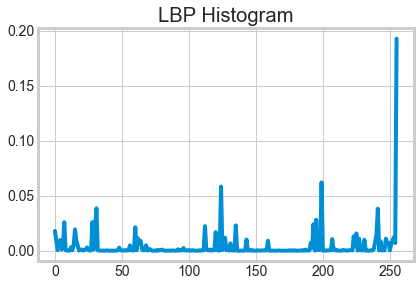

In [35]:
X_train,y_train=feature_lbpimg(train_list)


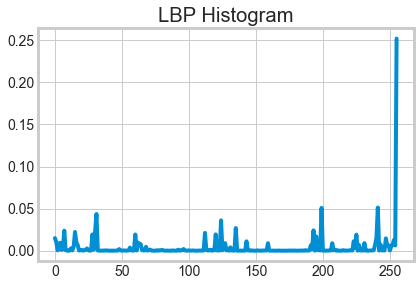

In [36]:
X_test,y_test=feature_lbpimg(test_list)

### Size and datatype of train and test sets

In [37]:
#Print the data type of x_train
print(type(X_train))
#Print the data type of y_train
print(type(y_train))
#Print the data type of x_test
print(type(X_test))
#Print the data type of y_test
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [38]:
#Print the data type of x_train
print(type(X_train))
#Print the data type of y_train
print(type(y_train))
#Print the data type of x_test
print(type(X_test))
#Print the data type of y_test
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## PCA with rbf Kernel

### Pre-process and Model’s Creation

In [39]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=150, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='rbf', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

### Hyperparameter Tuning

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [41]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

In [42]:
# check best parameters
print(best_params)

{'svc__C': 50, 'svc__gamma': 0.0001}


### Best model fit

In [43]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Result

- Classification Report

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      3362
           1       1.00      0.65      0.79      5761

    accuracy                           0.78      9123
   macro avg       0.81      0.82      0.78      9123
weighted avg       0.86      0.78      0.78      9123



- Confusion matrix

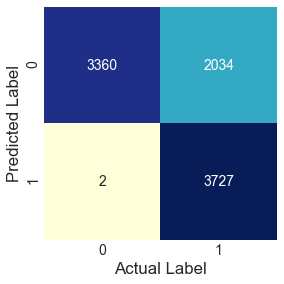

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [46]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'Raw image LBP + PCA-rbf SVM Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'Raw image LBP + PCA-rbf SVM Test HTER is {np.round(hter*100,2)}%')

Raw image LBP + PCA-rbf SVM Test accuracy is 77.68%
Raw image LBP + PCA-rbf SVM Test HTER is 17.68%


- ROC Curve

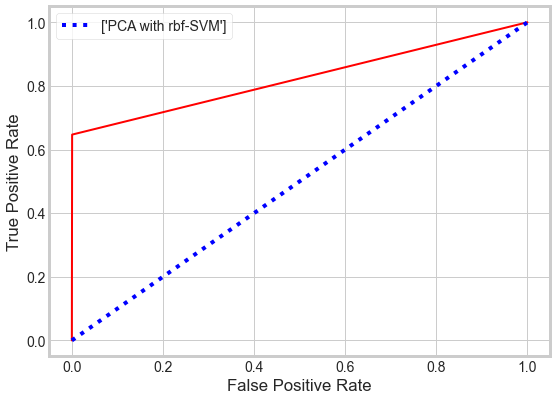

In [47]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['PCA with rbf-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## PCA with linear Kernel¶

### Preprocess and model's creation

In [48]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=150, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='linear', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

### Hyperparameter tuing

In [49]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [50]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

In [51]:
# check best parameters
print(best_params)

{'svc__C': 1, 'svc__gamma': 0.0001}


### Best model fit

In [52]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Result

- Classification Report

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      3362
           1       1.00      0.67      0.80      5761

    accuracy                           0.79      9123
   macro avg       0.82      0.84      0.79      9123
weighted avg       0.87      0.79      0.80      9123



- Confusion Matrix

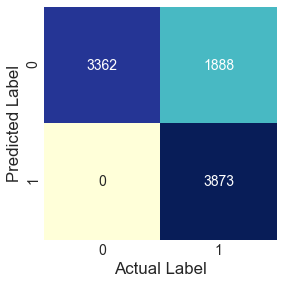

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [55]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'PCA-Linear SVM Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'Raw images LBP+ PCA-Linear SVM Test HTER is {np.round(hter*100,2)}%')

PCA-Linear SVM Test accuracy is 79.31%
Raw images LBP+ PCA-Linear SVM Test HTER is 16.39%


- ROC Curve

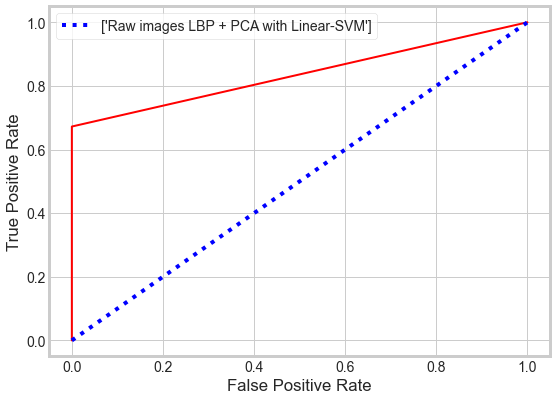

In [56]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['Raw images LBP + PCA with Linear-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# LBP Histogram- 64X64 images-PCA

## Feature Extraction

In [57]:
def feature_lbpimg_64(filelist):
    
    img_list=[]
    label_list=[]
    
    for i in range(len(filelist)):
      
        
      
      line=filelist[i]
      if (line.split('/')[1]=='ClientRaw'):
            label =0   
      else:
            label=1
      label_list.append(label)  
      img = cv2.imread(line)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img =cv2.resize(img,(64,64))
      hist_lbp = lbp_img(img)
      if(i==1):
        plt.plot(hist_lbp)
        plt.title('LBP of an image-64X64')
      img_list.append(np.array(hist_lbp))
    
    return np.array(img_list),np.array(label_list)

### Train and Test sets

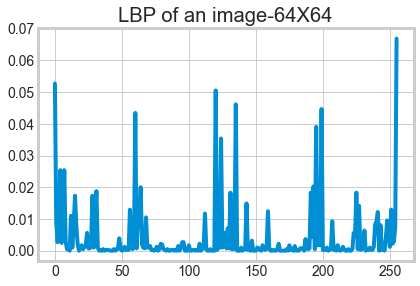

In [58]:
X_train,y_train=feature_lbpimg_64(train_list)


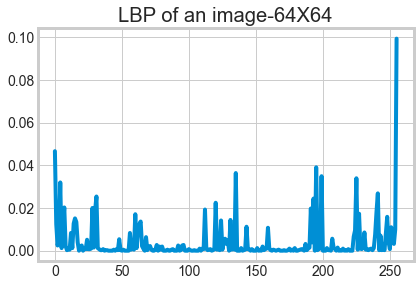

In [59]:
X_test,y_test=feature_lbpimg_64(test_list)


### Size and shape of train and test sets

In [60]:
#Print the data type of x_train
print(type(X_train))
#Print the data type of y_train
print(type(y_train))
#Print the data type of x_test
print(type(X_test))
#Print the data type of y_test
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [61]:
#Get the shape of x_train
print('X_train shape:', X_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('X_test shape:', X_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

X_train shape: (3491, 256)
y_train shape: (3491,)
X_test shape: (9123, 256)
y_test shape: (9123,)


## PCA with rbf Kernel

### Pre-process and Model's creation

In [62]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=150, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='rbf', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

### Hyperparameter tuning

In [63]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [64]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

In [65]:
# check best parameters
print(best_params)

{'svc__C': 1, 'svc__gamma': 0.0001}


### Best model fit

In [66]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Result

- Classification Report

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3362
           1       1.00      0.62      0.76      5761

    accuracy                           0.76      9123
   macro avg       0.80      0.81      0.76      9123
weighted avg       0.85      0.76      0.76      9123



- Confusion Matrix

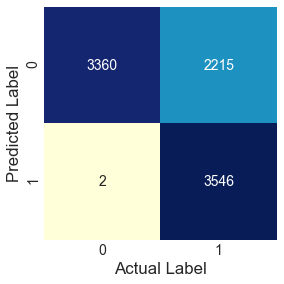

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [69]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'64X64 image LBP + PCA-rbf Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'64X64 image LBP + PCA-rbf Test HTER is {np.round(hter*100,2)}%')

64X64 image LBP + PCA-rbf Test accuracy is 75.7%
64X64 image LBP + PCA-rbf Test HTER is 19.25%


- ROC Curve

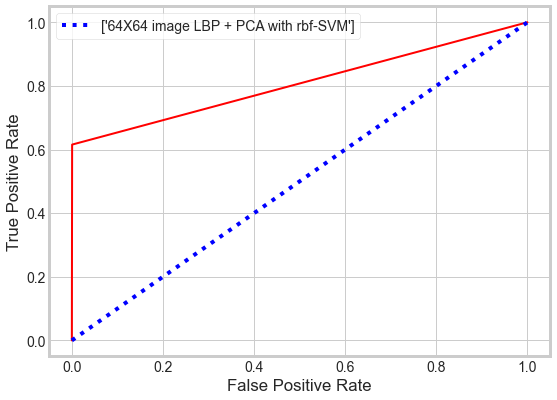

In [70]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['64X64 image LBP + PCA with rbf-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## PCA with linear Kernel

### Preprocess and model's creation

In [71]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# create dimenssion reduction
pca = PCA(n_components=150, whiten=True, random_state=42)
# create your SVM model with RBF kernel
svc = SVC(kernel='linear', class_weight='balanced')
# your pipline
model = make_pipeline(pca, svc)

### Hyperparameter tuning

In [72]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [73]:
warnings.filterwarnings('ignore')# ignore warnings
grid.fit(X_train, y_train)
best_params = grid.best_params_

In [74]:
# check best parameters
print(best_params)

{'svc__C': 1, 'svc__gamma': 0.0001}


### Best model fit

In [75]:
# best model we have
model = grid.best_estimator_
y_predicted = model.predict(X_test)

### Results

- Classification Report

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76      3362
           1       1.00      0.64      0.78      5761

    accuracy                           0.77      9123
   macro avg       0.81      0.82      0.77      9123
weighted avg       0.86      0.77      0.78      9123



- Confusion Matrix

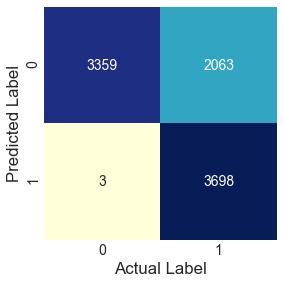

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

- Accuracy and HTER

In [ ]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test, y_predicted)
print(f'64X64 image LBP + PCA-Linear SVM Test accuracy is {np.round(accuracy*100,2)}%')
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).flatten()

far = fp / (fp + tn) # apcer
frr = fn / (tp + fn) # bpcer
hter=(far+frr) / 2 # acer
    
print(f'64X64 image LBP + PCA-Linear SVM Test HTER is {np.round(hter*100,2)}%')

- ROC Curve

In [ ]:
#  required libraries
from sklearn.metrics import roc_curve
# get false positive rates, true positive rates, for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
#plot the roc curve
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0,1],[0,1],'b:',label=['64X64 image LBP + PCA with Linear-SVM'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()